In [11]:
######################################################################
# Semi-Supervised Classification of Graph Nodes using Exponential Decay
# L42: Assessment 2
# Jan Ondras (jo356), Trinity College
######################################################################
# My Method - MLP_lambda:    training and testing, CITESEER dataset
######################################################################

#############################################################################################################
# Load data for final training + testing, uses my constructed EDNI features FOR CITESEER DATASET
#############################################################################################################

import keras
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import time
from gcn.utils import *

dataset_type = 'citeseer'

# Load data
_, _, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(dataset_type)

if dataset_type == 'citeseer':
    N_classes = 6
    N_features = 3703
    N_nodes = 3327
    N_edges = 4676 #4732 - incorrect in GCN paper !
    if N_classes != y_train.shape[1]:
        raise ValueError("Dataset dimensions differ from expected!")
else:
    raise ValueError("Dataset not supported!")
print dataset_type, "dataset:", "#classes =", N_classes, ", #features =", N_features, ", #nodes =", N_nodes, ", #edges =", N_edges

# Prepare labels
y_train = y_train[train_mask]
y_val = y_val[val_mask]
y_test = y_test[test_mask]

train_batch_size = len(y_train)
val_batch_size = len(y_val)
test_batch_size = len(y_test)

print "Labels shapes (train, valid, test):", y_train.shape, y_val.shape, y_test.shape

citeseer dataset: #classes = 6 , #features = 3703 , #nodes = 3327 , #edges = 4676
Labels shapes (train, valid, test): (120, 6) (500, 6) (1000, 6)


In [18]:
#############################################################################################################
# Load tuned parameters - from Baseline MLP validation on CITESEER dataset
#############################################################################################################

ID = 0 # zeroth trial,  smaller # of hidden sizes
ID = 1 # first ok trial, higher # of hidden sizes

# data = np.load('./../../../Dataset/baseline_' + str(ID) + '.npz')
data = np.load('./../../../Dataset/baseline_' + str(ID) + '_Citeseer.npz') # params for Baseline MLP validated on Citeseer dataset

vals = data['vals']
vals_std = data['vals_std']
N_hl_range = data['N_hl_range']
N_hu_range = data['N_hu_range']
N_runs = data['N_runs']
dropout = data['dropout']
epochs = data['epochs']

best_N_hl = N_hl_range[np.argmax(vals) // len(N_hu_range)]
best_N_hu = N_hu_range[np.argmax(vals) % len(N_hu_range)]

print "# hidden layers range", N_hl_range
print "# hidden units range", N_hu_range
print "Optimal number of hidden layers: ", best_N_hl
print "Optimal number of hidden units: ",  best_N_hu
print "dropout", dropout, "\tN_runs", N_runs

# hidden layers range [ 1  2  3  4  5  6  7  8  9 10]
# hidden units range [10 15 20 25 30 35 40 45 50 55 60 65 70 75 80]
Optimal number of hidden layers:  3
Optimal number of hidden units:  50
dropout 0.5 	N_runs 100


In [26]:
#############################################################################################################
# Final train & Test for each LAMBDA
# Using best N_hl and N_hu found for the baseline method on Cora dataset
# no feature scaling
#############################################################################################################
# for all possible lambdas
lambdas = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 
           6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 
           100.0, 200.0, 300.0, 400.0, 500.0, 1000.0]
print "Processing", len(lambdas), "lambdas."

test_acc = []
test_acc_std = []

N_hl = best_N_hl
N_hu = best_N_hu

for LAMBDA in lambdas: 

    st = time.time()
    X = np.load('./../../../Dataset/Features_Citeseer/f_' + str(LAMBDA) + '_.npz')['X']
    if LAMBDA != np.load('./../../../Dataset/Features_Citeseer/f_' + str(LAMBDA) + '_.npz')['LAMBDA']:
        raise ValueError("Lambdas don't agree!")
    print "Max and Min feature value in new feature set:", np.max(X), np.min(X), X.shape

    X_train = X[train_mask]
    X_val   = X[val_mask]
    X_test  = X[test_mask]

    # Train & test for this LAMBDA
    model = Sequential()
    model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
    model.add(Dropout(dropout))
    for i in range(1, N_hl):
        model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(dropout))
    model.add(Dense(N_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
#     print model.summary()
    early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0) # stop after 10 epochs without improvement in val_acc

    test_acc_actual = []
    for i in range(N_runs):
        model.fit(X_train, y_train, epochs=epochs, batch_size=train_batch_size, 
                   validation_data = (X_val, y_val), verbose=0, callbacks=[early_stop])

        test_acc_actual.append( model.evaluate(X_test, y_test, batch_size=test_batch_size, verbose=0)[1] )
        
    test_acc.append( np.mean(test_acc_actual) )
    test_acc_std.append( np.std(test_acc_actual) )  
    
    print "Time taken: ", time.time()-st, (time.time()-st)/60. 
    
test_acc = np.array(test_acc)
test_acc_std = np.array(test_acc_std)

Processing 36 lambdas.
Max and Min feature value in new feature set: 2.43949725325 0.0 (3327, 3703)
Time taken:  139.975044966 2.3329265515
Max and Min feature value in new feature set: 13.1492786963 0.0 (3327, 3703)
Time taken:  81.3128221035 1.35521468719
Max and Min feature value in new feature set: 28.5438876818 0.0 (3327, 3703)
Time taken:  84.5281450748 1.40880320072
Max and Min feature value in new feature set: 44.7771139186 0.0 (3327, 3703)
Time taken:  98.2401468754 1.63733856678
Max and Min feature value in new feature set: 60.4883811993 0.0 (3327, 3703)
Time taken:  94.1954550743 1.56992713213
Max and Min feature value in new feature set: 75.2067150501 0.0 (3327, 3703)
Time taken:  82.1631920338 1.36938716571
Max and Min feature value in new feature set: 88.8105659357 0.0 (3327, 3703)
Time taken:  91.7018358707 1.52836474975
Max and Min feature value in new feature set: 105.639767002 0.0 (3327, 3703)
Time taken:  89.838201046 1.49730401436
Max and Min feature value in new fe

In [27]:
# To save the testing results
print test_acc.tolist()
print test_acc_std.tolist()

# [0.5558600008487702, 0.6441199994087219, 0.6549699991941452, 0.6059299984574318, 0.4404400023818016, 0.47425000101327897, 0.46889999985694886, 0.3215300000458956, 0.2367099991440773, 0.2982999996840954, 0.19153000071644782, 0.23587000027298927, 0.25244999915361405, 0.26637000024318697, 0.2299600002914667, 0.18315999910235406, 0.22879999965429307, 0.2086800006777048, 0.2213799986988306, 0.22171999961137773, 0.22588999986648559, 0.20247000008821486, 0.23011999905109407, 0.23152999967336654, 0.21007000014185906, 0.23068999968469142, 0.22658999919891357, 0.17575999975204468, 0.20401999920606614, 0.2001799999177456, 0.204529999345541, 0.21567999988794326, 0.1897400002926588, 0.2162200003862381, 0.21747000023722649, 0.19086999982595443]
# [0.01432760892214896, 0.0066185782293885845, 0.007384381808736592, 0.033374020174716475, 0.014487457188884945, 0.04984182599888458, 0.05137324214202001, 0.07935659470264748, 0.03260591698183285, 0.024181191050162528, 0.013654637019411248, 0.025485546466980844, 0.014310398230466433, 0.015270662312966643, 0.03254133300388936, 0.033217380706210387, 0.010705138337054334, 0.04336355166003854, 0.03583762854987894, 0.014133704299782711, 0.04445129854800063, 0.037158163431927564, 0.022802315401203286, 0.02440428475769273, 0.02220732021051682, 0.021705619171743865, 0.03492279858819937, 0.034921660378892716, 0.026162562099077347, 0.04066334452223994, 0.023340717578576996, 0.024941082676925092, 0.01631908041761595, 0.0115529910137204, 0.0066969475611151985, 0.02448250602435723]


[0.5558600008487702, 0.6441199994087219, 0.6549699991941452, 0.6059299984574318, 0.4404400023818016, 0.47425000101327897, 0.46889999985694886, 0.3215300000458956, 0.2367099991440773, 0.2982999996840954, 0.19153000071644782, 0.23587000027298927, 0.25244999915361405, 0.26637000024318697, 0.2299600002914667, 0.18315999910235406, 0.22879999965429307, 0.2086800006777048, 0.2213799986988306, 0.22171999961137773, 0.22588999986648559, 0.20247000008821486, 0.23011999905109407, 0.23152999967336654, 0.21007000014185906, 0.23068999968469142, 0.22658999919891357, 0.17575999975204468, 0.20401999920606614, 0.2001799999177456, 0.204529999345541, 0.21567999988794326, 0.1897400002926588, 0.2162200003862381, 0.21747000023722649, 0.19086999982595443]
[0.01432760892214896, 0.0066185782293885845, 0.007384381808736592, 0.033374020174716475, 0.014487457188884945, 0.04984182599888458, 0.05137324214202001, 0.07935659470264748, 0.03260591698183285, 0.024181191050162528, 0.013654637019411248, 0.025485546466980844

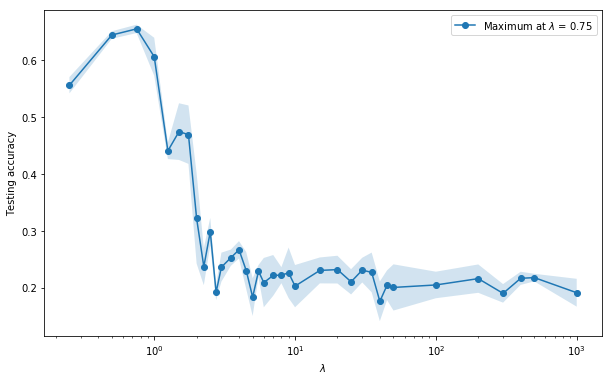

Max Testing accuracy:  0.654969999194 +/- 0.00738438180874 for 0.75
Citeseer


In [31]:
#############################################################################################################
# Show testing results, for chosen lambdas
#############################################################################################################

lambdas = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 
           6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 
           100.0, 200.0, 300.0, 400.0, 500.0, 1000.0]

N_std = 1
showN = 36 # max 36
plt.figure(figsize=[10,6])
plt.plot(lambdas[:showN], test_acc[:showN],'o-')
plt.fill_between(lambdas[:showN],  test_acc[:showN]-N_std*test_acc_std[:showN],  test_acc[:showN]+N_std*test_acc_std[:showN], alpha=.2)
# plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('$\lambda$')
plt.ylabel('Testing accuracy')
#plt.xticks(lambdas[:showN], lambdas[:showN])#, rotation=45)
plt.legend(['Maximum at $\lambda$ = '+str(lambdas[np.argmax(test_acc)])])
plt.xscale('log')
plt.show()

print "Max Testing accuracy: ",np.max(test_acc), "+/-", test_acc_std[np.argmax(test_acc)], "for", lambdas[np.argmax(test_acc)]
print "Citeseer"

In [ ]:
Max Testing accuracy:  0.654969999194 +/- 0.00738438180874 for 0.75